In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.text import *
from pathlib import Path

In [2]:
LM_WIKI_PATH = Path('./LM')

# Reformate csv

In [ ]:
df_train = pd.read_csv(LM_WIKI_PATH/'train.csv', header=None)
df_valid = pd.read_csv(LM_WIKI_PATH/'val.csv', header=None)

In [ ]:
df_all = pd.concat([df_train, df_valid], ignore_index=True)
df_all['label'] = 0
df_all.columns = [1,0]
df_all = df_all[[0,1]]

In [ ]:
df_all.head()

In [ ]:
df_all.to_csv(LM_WIKI_PATH/'texts.csv', index=False)

# Preparing the data¶

In [3]:
data_lm = TextDataBunch.from_csv(LM_WIKI_PATH,
                                 'texts.csv',
                                 valid_pct=0.1,
                                 chunksize=1000,
                                 tokenizer=Tokenizer(lang='es'))


data_lm.save('LM_wiki')

KeyboardInterrupt: 

# Language model

In [3]:
def convert(path_to_old_model, path_to_save_converted_model):
    """
    path_to_old_model is the path to old model (before fast.ai v1)
    and 
    path_to_save_converted_model is the path where the converted model is stored
    """
    old_wgts = torch.load(path_to_old_model, map_location=lambda storage, loc: storage)
    new_wgts = OrderedDict()
    new_wgts['0.encoder.weight']=old_wgts['0.encoder.weight']
    new_wgts['0.encoder_dp.emb.weight']=old_wgts['0.encoder_with_dropout.embed.weight']
    new_wgts['0.rnns.0.weight_hh_l0_raw']=old_wgts['0.rnns.0.module.weight_hh_l0_raw']
    new_wgts['0.rnns.0.module.weight_ih_l0']=old_wgts['0.rnns.0.module.weight_ih_l0']
    new_wgts['0.rnns.0.module.weight_hh_l0']=old_wgts['0.rnns.0.module.weight_hh_l0_raw']
    new_wgts['0.rnns.0.module.bias_ih_l0']=old_wgts['0.rnns.0.module.bias_ih_l0']
    new_wgts['0.rnns.0.module.bias_hh_l0']=old_wgts['0.rnns.0.module.bias_hh_l0']
    new_wgts['0.rnns.1.weight_hh_l0_raw']=old_wgts['0.rnns.1.module.weight_hh_l0_raw']
    new_wgts['0.rnns.1.module.weight_ih_l0']=old_wgts['0.rnns.1.module.weight_ih_l0']
    new_wgts['0.rnns.1.module.weight_hh_l0']=old_wgts['0.rnns.1.module.weight_hh_l0_raw']
    new_wgts['0.rnns.1.module.bias_ih_l0']=old_wgts['0.rnns.1.module.bias_ih_l0']
    new_wgts['0.rnns.1.module.bias_hh_l0']=old_wgts['0.rnns.1.module.bias_hh_l0']
    new_wgts['0.rnns.2.weight_hh_l0_raw']=old_wgts['0.rnns.2.module.weight_hh_l0_raw']
    new_wgts['0.rnns.2.module.weight_ih_l0']=old_wgts['0.rnns.2.module.weight_ih_l0']
    new_wgts['0.rnns.2.module.weight_hh_l0']=old_wgts['0.rnns.2.module.weight_hh_l0_raw']
    new_wgts['0.rnns.2.module.bias_ih_l0']=old_wgts['0.rnns.2.module.bias_ih_l0']
    new_wgts['0.rnns.2.module.bias_hh_l0']=old_wgts['0.rnns.2.module.bias_hh_l0']
    new_wgts['1.decoder.bias'] = torch.rand(60002)

    torch.save(new_wgts, path_to_save_converted_model/'converted_lm1_weights.h5')
    


In [4]:
#convert(LM_WIKI_PATH/'LM_wiki_old/lm1_weights.h5', LM_WIKI_PATH/'LM_wiki')

In [3]:
bs=128

In [4]:
data_lm =  TextLMDataBunch.load(LM_WIKI_PATH, 'LM_wiki' , bs=bs)

In [5]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3, pretrained=False)

In [6]:
learn.load_pretrained('./LM/LM_wiki/converted_lm1_weights.h5', './LM/LM_wiki_old/itos.pkl')
learn.unfreeze()

In [7]:
learn.lr_find(num_it=500)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


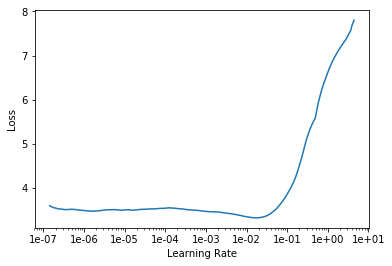

In [8]:
learn.recorder.plot()

In [ ]:
lr = 1e-02
learn.fit_one_cycle(1, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time


In [ ]:
learn.save('fine_tuned')